## DNO fault data test

Creating plots of fault data, segregated by weather-related fault codes

MW, 16/7/25

### Data issues (16/7/25):
- No data frmo NGED or UKPN -- neither included here
- No fault code assignment from SPEN -- so not included here
- Data from ENWL only goes to 25/1/25
- SSEN data is HV only

### Methodology:
- All data pre-weighted by cosine-weighted population (see dno_population.ipynb)
- Normalisation is by dividing by the maximum magnitude (across all weather-related fault codes, across all DNOs for which we have data) of CML / customers affected to produce a value between 0 and 1
- Regions are defined as outlined here: https://eaguk.org/distribution-network-operator-dno/
- Fault codes are described here: https://drive.google.com/file/d/1pIDCdztiT8vd-CIZkG4AHEnyl5xw4NEH/view?usp=sharing
    - Directly wind related = 6 (wind/gale) and 21 (windborne material)
    - Directly precipitation related = 2 (rain), 3 (snow and sleet) and 18 (flooding)
    - Heat related = 7 (extreme heat)
    - Lightning = 1
    - Trees falling (indirectly wind related?) = 23 (live trees), 24 (dead trees)
    - Ice and frost = 4 (ice) and 5 (freezing fog and frost)

In [1]:
# standard libraries
from pathlib import Path

# maths libraries
import numpy as np

# geodata libraries
import pandas as pd
import geopandas as gpd
import shapely
import rasterio

# plotting libraries (not required for the actual calculations)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
# Set up a dictionary for storms
storms = {
    "Storm Ashley": ["2024-10-18", "2024-10-21"],
    "Storm Bert": ["2024-11-21", "2024-11-25"],
    "Storm Conall": ["2024-11-26", "2024-11-27"],
    "Storm Darragh": ["2024-12-05", "2024-12-07"],
    "Storm Éowyn": ["2025-01-21", "2025-01-24"],
    # "Storm Henk": ["2024-01-02", "2024-01-02"],
    # "Storm Isha": ["2024-01-19", "2024-01-22"],
#     "Storm Jocelyn": ["2024-01-22", "2024-01-24"],
    "Storm Kathleen": ["2024-04-04", "2024-04-07"],
    "Storm Lilian": ["2024-08-22", "2024-08-23"],
}

# Set up different colours for the storms
storm_colours = {
    "Storm Ashley": "red",
    "Storm Bert": "blue",
    "Storm Conall": "green",
    "Storm Darragh": "purple",
    "Storm Éowyn": "orange",
    # "Storm Henk": "cyan",
    # "Storm Isha": "magenta",
    # "Storm Jocelyn": "yellow",
    "Storm Kathleen": "brown",
    "Storm Lilian": "pink",
}

In [3]:
region_dict = {
    15: 'North East England (NPG)',
    16: 'North West England (ENWL)',
    17: 'North Scotland (SSEN)',
    20: 'South East England (SSEN)',
    23: 'Yorkshire (NPG)'
    # Add more as more DNO data is available to be plotted
}

#Set up colours when plotting all regions on same plot
region_colors = {
    15: 'blue',
    16: 'orange',
    17: 'green',
    20: 'red',
    23: 'pink'
}


In [4]:
# Set uip the path to the full wind gust data
full_wind_gust_file_path = "../saved_dfs/max_10m_wind_gusts_timeseries_DNO_areas_Apr_2024-Apr_2025.csv"

# Load in the full wind gust data
full_wind_gust_data = pd.read_csv(full_wind_gust_file_path, low_memory=False)

# Set "Unnamed: 0" as the index
full_wind_gust_data.set_index("Unnamed: 0", inplace=True)

# rename the index as time
full_wind_gust_data.index.name = "Time"

# Ensure this index is in datetime format
full_wind_gust_data.index = pd.to_datetime(full_wind_gust_data.index)

# Aggregate the data to daily frequency, by summing the values for each day
full_wind_gust_data_daily = full_wind_gust_data.resample('D').max()

In [5]:
full_wind_gust_data_daily.head()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
Time,,,,,,,,,,,,,,
2024-04-01,12.226207,11.392228,12.329113,10.759416,10.169626,15.243357,14.412736,18.108994,14.078720,10.310197,13.380504,12.737931,17.265118,14.190048
2024-04-02,12.640571,11.954674,12.467369,10.459928,10.680170,9.010651,9.270453,21.265261,16.845497,13.707710,17.907839,9.157263,12.654850,17.111103
2024-04-03,18.231998,17.777897,17.880499,17.092350,17.099186,16.338507,15.870459,20.265039,20.234015,17.461988,18.037500,16.518290,14.514835,18.816481
2024-04-04,18.127800,14.715985,17.845573,15.755416,16.861862,12.414570,14.721236,17.454636,18.803934,19.388229,26.356003,11.396992,16.217331,18.469980
2024-04-05,20.810612,22.454720,19.073399,22.942448,23.753483,19.525333,19.698860,21.651762,20.469883,25.304264,26.637262,20.034575,18.143583,22.080893


In [6]:
# Set uip the path to the full wind gust data
full_accum_precip_file_path = "../saved_dfs/total_precip_timeseries_dno_areas_April_2024-April_2025.csv"

# Load in the full wind gust data
full_accum_precip_data = pd.read_csv(full_accum_precip_file_path, low_memory=False)

# Set "Unnamed: 0" as the index
full_accum_precip_data.set_index("Unnamed: 0", inplace=True)

# rename the index as time
full_accum_precip_data.index.name = "Time"

# Ensure this index is in datetime format
full_accum_precip_data.index = pd.to_datetime(full_accum_precip_data.index)

# Aggregate the data to daily frequency, by summing the values for each day
full_accum_precip_data_daily = full_accum_precip_data.resample('D').max()

In [7]:
full_accum_precip_data_daily.head()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
Time,,,,,,,,,,,,,,
2024-04-01,14.341354,7.378101,3.781319,15.669823,16.551971,23.610115,18.094063,37.229538,10.313034,24.639130,19.485950,11.964798,37.861824,35.172462
2024-04-02,36.684990,35.999298,3.270149,16.780853,19.755840,5.684376,5.306244,32.489777,16.307831,32.551765,28.669357,9.259224,13.367653,30.263901
2024-04-03,19.373417,30.450344,2.243996,15.391350,18.208981,45.241833,31.111240,43.523788,14.286995,15.880108,22.926331,12.724876,60.818672,33.630371
2024-04-04,53.154469,23.147583,1.887798,22.480965,21.106720,19.480228,30.351162,16.429901,10.896683,22.971153,24.967194,20.408154,31.040192,27.904987
2024-04-05,19.748211,36.500454,0.926018,33.740997,33.937931,41.245461,45.994282,135.082722,5.349636,61.604023,42.285442,29.861927,83.239079,24.275780


In [58]:
# Load all fault data (already combined into one file and filtered to remove non-meteorological faults)
all_fault_data = pd.read_csv('../faults/fault_data/combined_weather_fault_data_normalised.csv', usecols=lambda x: not x.startswith("Unnamed"),)

In [59]:
#Drop NANs and combine date and time
all_fault_data = all_fault_data.dropna(subset=['Start date'])
all_fault_data['Start date'] = pd.to_datetime(
    all_fault_data['Start date']
)


In [49]:
all_fault_data.head()

,DNO,Cause,Code,Category,Start date,Start time,Duration (minutes),CML,Population-weight CML,Normalised population-weighted CML,Customers affected,Population-weight customers affected,Normalised population-weighted customers affected,Voltage,Region,Location,Latitude,Longitude
7,SSEN,Falling live trees (not felled),23.0,Trees,2024-04-04,07:01:00,205.0,54862,3324969.697,0.012076,267,16181.818180,0.021914,33.0,17.0,ARGYLL,NaN,NaN
12,SSEN,Lightning,1.0,Lightning,2024-04-05,06:45:00,157.0,105102,6369818.182,0.023135,670,40606.060610,0.054990,33.0,17.0,ARGYLL,NaN,NaN
19,SSEN,Wind and Gale (excluding Windborne Material),6.0,Wind,2024-04-06,09:01:00,213.0,266314,16140242.42,0.058621,1249,75696.969700,0.102512,33.0,17.0,HIGH,NaN,NaN
34,SSEN,Wind and Gale (excluding Windborne Material),6.0,Wind,2024-04-06,20:00:00,362.0,3260,197575.7576,0.000718,9,545.454545,0.000739,33.0,17.0,ARGYLL,NaN,NaN
35,SSEN,Wind and Gale (excluding Windborne Material),6.0,Wind,2024-04-06,20:05:00,200.0,1200,72727.27273,0.000264,6,363.636364,0.000492,33.0,17.0,ARGYLL,NaN,NaN


In [50]:
all_fault_data['DNO'].unique()

array(['SSEN', 'NPG', 'ENWL'], dtype=object)

### Wind faults

In [70]:
#Wind faults
wind_faults = all_fault_data[all_fault_data['Category'] == 'Wind'].drop(['Cause', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Normalised population-weighted CML', 'Customers affected', 'Normalised population-weighted customers affected', 'Voltage', 'Location', 'Latitude', 'Longitude'], axis=1)
wind_faults['Population-weight CML'] = wind_faults['Population-weight CML'].astype(str).str.replace(',', '').astype(float)
wind_faults['Population-weight customers affected'] = wind_faults['Population-weight customers affected'].astype(float)
wind_faults = wind_faults.groupby(['Region', 'Start date', 'DNO'], as_index=False).sum()



In [74]:
wind_faults['Population-weight CML'] = wind_faults.groupby("Region")["Population-weight CML"].transform(lambda x: x / x.max())
wind_faults['Population-weight customers affected'] = wind_faults.groupby("Region")["Population-weight customers affected"].transform(lambda x: x / x.max())
wind_faults.head()

,Region,Start date,DNO,Code,Population-weight CML,Population-weight customers affected
0,15.0,2024-04-06,NPG,18.0,0.005422,0.008066
1,15.0,2024-04-07,NPG,12.0,0.000798,0.004358
2,15.0,2024-04-22,NPG,6.0,0.000042,0.000066
3,15.0,2024-04-25,NPG,6.0,0.000014,0.000066
4,15.0,2024-04-27,NPG,6.0,0.000031,0.000113


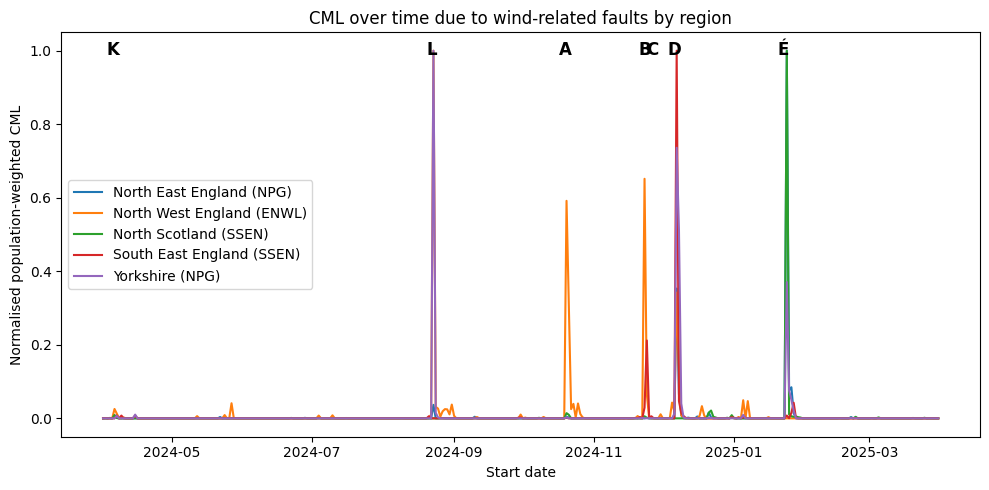

In [77]:
#Plot wind fault CML

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    subset = wind_faults[wind_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Population-weight CML'],
        label=region_name
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted CML')
plt.title('CML over time due to wind-related faults by region')
plt.legend()
plt.tight_layout()
plt.show()

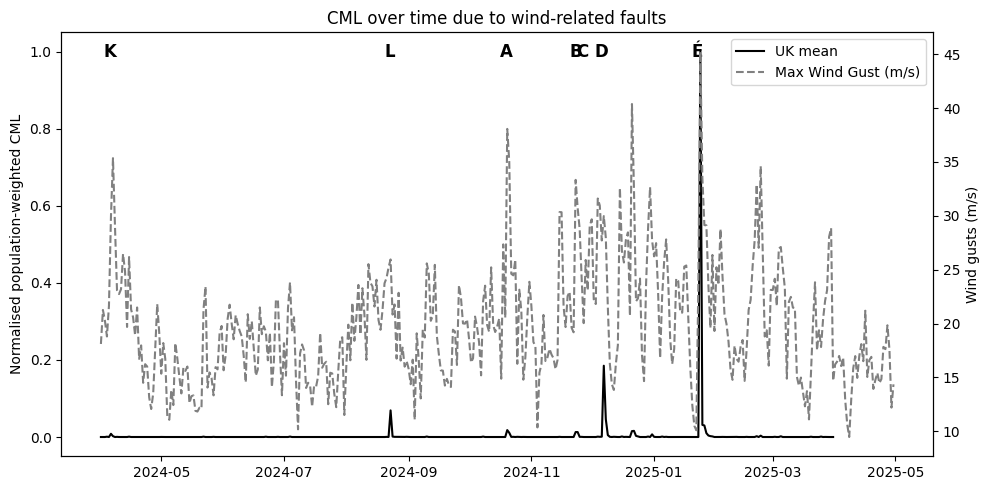

In [88]:
#Plot wind fault CML

plt.figure(figsize=(10,5))

subset = all_fault_data[all_fault_data['Category'] == 'Wind'].drop(['Cause', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Normalised population-weighted CML', 'Customers affected', 'Normalised population-weighted customers affected', 'Voltage', 'Location', 'Latitude', 'Longitude'], axis=1)
subset['Population-weight CML'] = subset['Population-weight CML'].astype(str).str.replace(',', '').astype(float)
subset['Population-weight customers affected'] = subset['Population-weight customers affected'].astype(float)
subset = subset.groupby(['Start date'], as_index=False).sum('Region')
subset['Population-weight CML'] = subset['Population-weight CML'].transform(lambda x: x / x.max())
subset['Population-weight customers affected'] = subset['Population-weight customers affected'].transform(lambda x: x / x.max())
subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
plt.plot(
    subset.index,
    subset['Population-weight CML'],
    label='UK mean',
    color='k',
)

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip 'Storm ' prefix)
    first_letter = storm.split()[1][0]  # e.g. 'Ashley' -> 'A'
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

handles1, labels1 = plt.gca().get_legend_handles_labels()
plt.ylabel('Normalised population-weighted CML')

ax2 = plt.gca().twinx()
gust_region_list = [region_name.split(' (')[0] for region_name in list(region_dict.values())]
wind_gust_subset = full_wind_gust_data_daily[gust_region_list].max(axis=1)

ax2.plot(
    wind_gust_subset.index,
    wind_gust_subset,
    color='grey',
    linestyle='--',
    label='Max Wind Gust (m/s)',
    )

ax2.set_ylabel('Wind gusts (m/s)')

plt.xlabel('Start date')
plt.title('CML over time due to wind-related faults')

# aggregate the legends together

handles2, labels2 = ax2.get_legend_handles_labels()
# Combine the handles and labels
combined_handles = handles1 + handles2
combined_labels = labels1 + labels2
plt.legend(combined_handles, combined_labels)
plt.tight_layout()
plt.show()

In [55]:
gust_region_list = [region_name.split(' (')[0] for region_name in list(region_dict.values())]
wind_gust_subset = full_wind_gust_data_daily[gust_region_list]

wind_gust_subset.head()

,North East England,North West England,North Scotland,South East England,Yorkshire
Time,,,,,
2024-04-01,15.243357,14.412736,18.108994,14.078720,12.737931
2024-04-02,9.010651,9.270453,21.265261,16.845497,9.157263
2024-04-03,16.338507,15.870459,20.265039,20.234015,16.518290
2024-04-04,12.414570,14.721236,17.454636,18.803934,11.396992
2024-04-05,19.525333,19.698860,21.651762,20.469883,20.034575


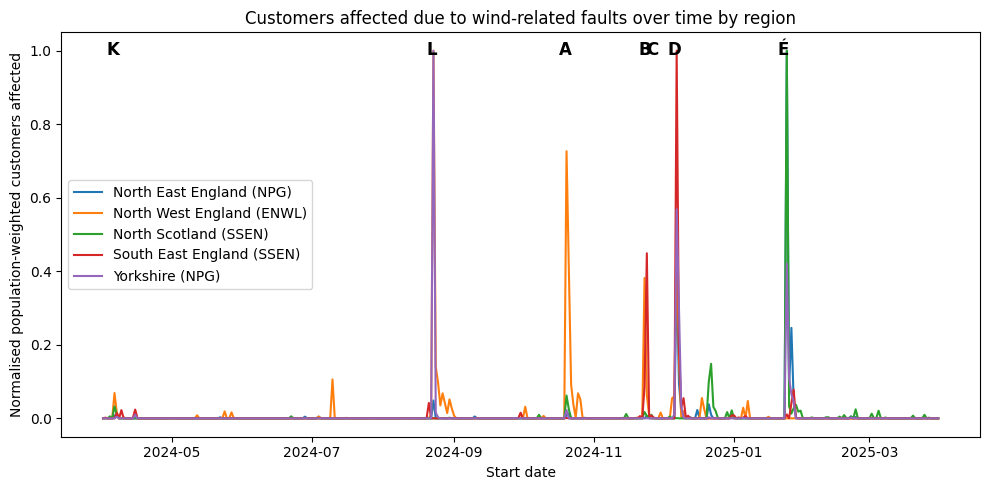

In [89]:
#Plot wind fault number of customers affected

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    subset = wind_faults[wind_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Population-weight customers affected'],
        label=region_name
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted customers affected')
plt.title('Customers affected due to wind-related faults over time by region')
plt.legend()
plt.tight_layout()
plt.show()

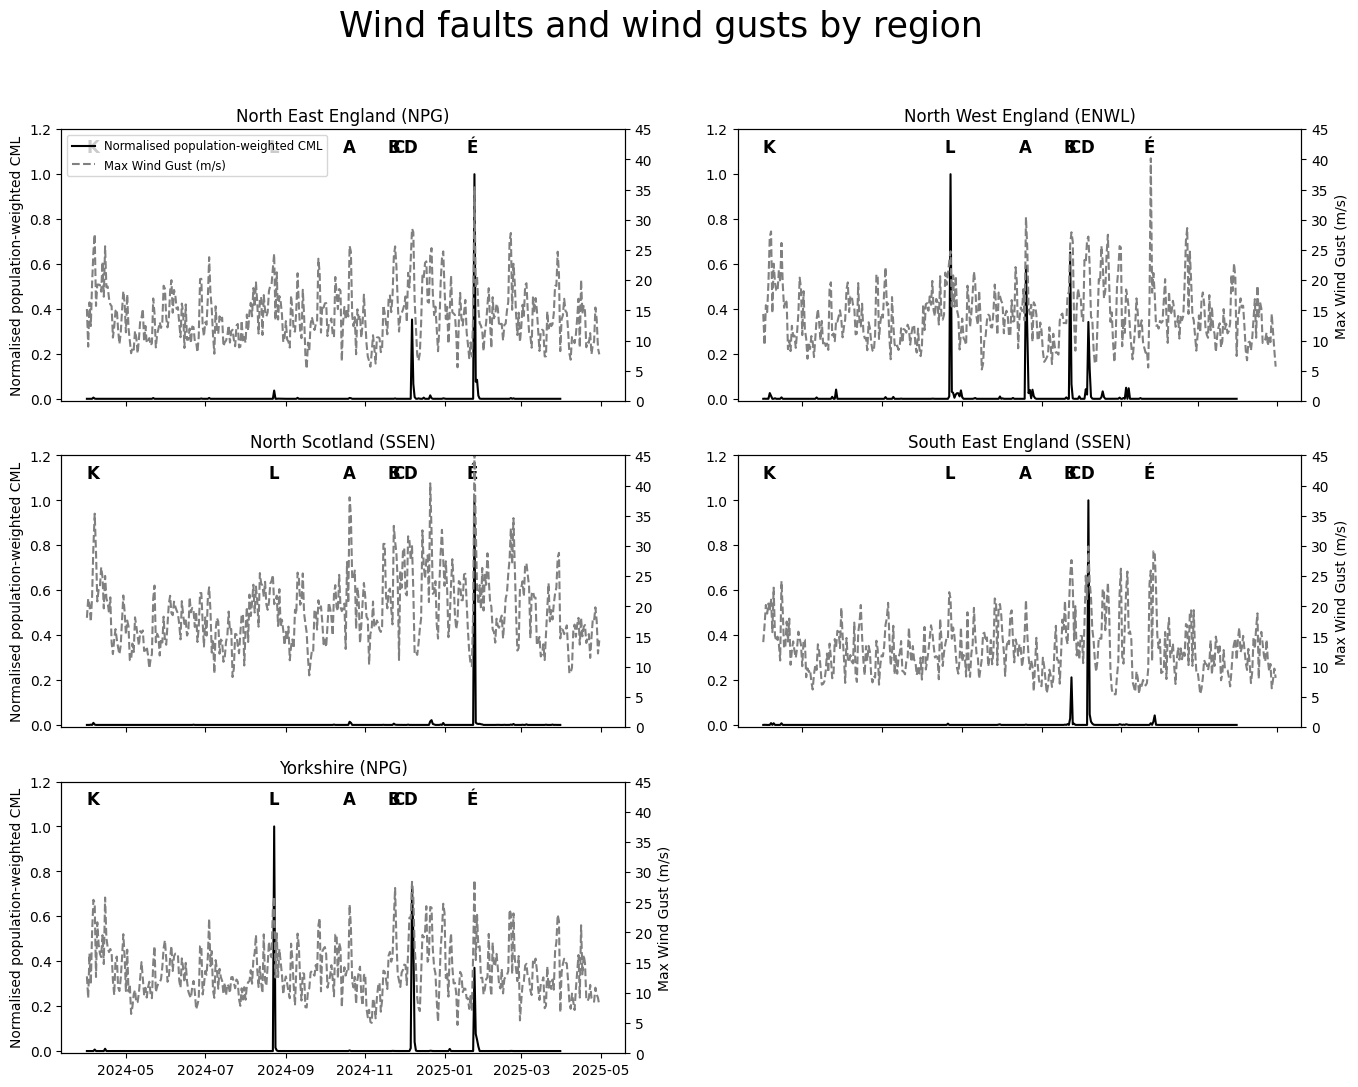

In [92]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 12), sharex=True)
axs = axs.flatten()

for i, (region_number, region_name) in enumerate(region_dict.items()):
    subset = wind_faults[wind_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    axs[i].plot(
        subset.index,
        subset['Population-weight CML'],
        color='k',
        label=['Normalised population-weighted CML']
    )
    axs[i].set_title(region_name)
    axs[i].set_ylim(-0.01,1.2)

    # Loop through the storms and plot the time periods
    for storm, dates in storms.items():
        start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
        end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
        # Midpoint of the storm period
        midpoint = start_date + (end_date - start_date) / 2
        # First letter of the storm name (skip "Storm " prefix)
        first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
        # Place the letter just at the top of the plot
        axs[i].text(midpoint, axs[i].set_ylim()[1]*0.9, first_letter, color='k',
                fontsize=12, fontweight='bold', ha='center', va='bottom')
        
    ax2_this = axs[i].twinx()

    ax2_this.plot(
        full_wind_gust_data_daily.index,
        full_wind_gust_data_daily[region_name.split(' (')[0]],
        color="grey",
        linestyle="--",
        label="Max Wind Gust (m/s)",
    )
    ax2_this.set_ylim(0,45)

    if i in [0, 2, 4]:
        axs[i].set_ylabel("Normalised population-weighted CML")
    else:
        axs[i].set_xlabel("")

    if i in [1, 3, 4]:
        ax2_this.set_ylabel("Max Wind Gust (m/s)")
    else:
        ax2_this.set_ylabel("")

    # aggregate the legends together
    handles, labels = axs[i].get_legend_handles_labels()
    handles2, labels2 = ax2_this.get_legend_handles_labels()
    # Combine the handles and labels
    combined_handles = handles + handles2
    combined_labels = labels + labels2
    # if i is 0 include the legend in the top left
    if i == 0:
        axs[i].legend(combined_handles, combined_labels, loc="upper left", fontsize="small")

axs[5].axis('off')
plt.suptitle('Wind faults and wind gusts by region', fontsize=25)
plt.show()


### Precipitation faults

In [94]:
#precip faults
precip_faults = all_fault_data[all_fault_data['Category'] == 'Precipitation'].drop(['Cause', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Normalised population-weighted CML', 'Customers affected', 'Normalised population-weighted customers affected', 'Voltage', 'Location', 'Latitude', 'Longitude'], axis=1)
precip_faults['Population-weight CML'] = precip_faults['Population-weight CML'].astype(str).str.replace(',', '').astype(float)
precip_faults['Population-weight customers affected'] = precip_faults['Population-weight customers affected'].astype(float)
precip_faults = precip_faults.groupby(['Region', 'Start date', 'DNO'], as_index=False).sum()



In [95]:
precip_faults['Population-weight CML'] = precip_faults.groupby("Region")["Population-weight CML"].transform(lambda x: x / x.max())
precip_faults['Population-weight customers affected'] = precip_faults.groupby("Region")["Population-weight customers affected"].transform(lambda x: x / x.max())
precip_faults.head()

,Region,Start date,DNO,Code,Population-weight CML,Population-weight customers affected
0,15.0,2024-05-13,NPG,2.0,0.000295,0.000054
1,15.0,2024-05-22,NPG,2.0,0.000911,0.000162
2,15.0,2024-05-30,NPG,18.0,0.002659,0.003451
3,15.0,2024-05-31,NPG,2.0,0.000085,0.000162
4,15.0,2024-06-11,NPG,2.0,0.000000,0.000000


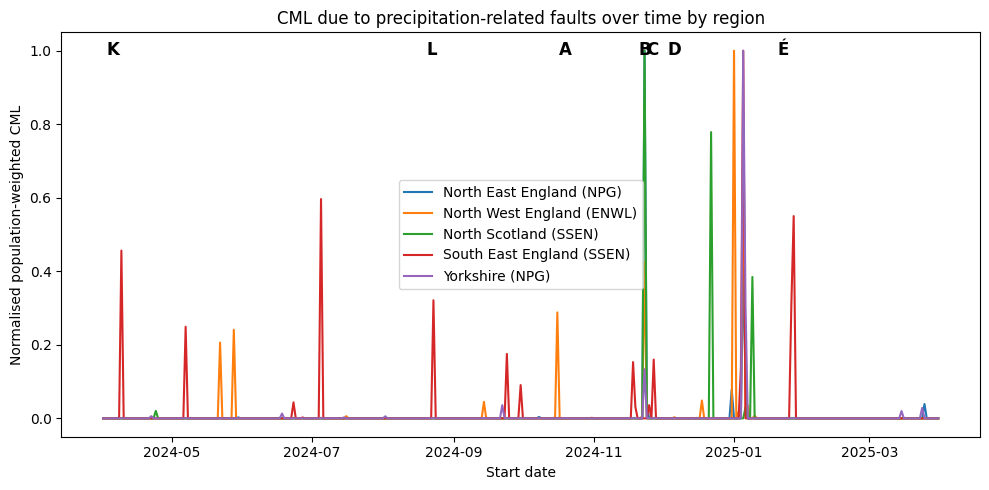

In [96]:
#Plot precip fault CML

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    subset = precip_faults[precip_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Population-weight CML'],
        label=region_name
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted CML')
plt.title('CML due to precipitation-related faults over time by region')
plt.legend()
plt.tight_layout()
plt.show()

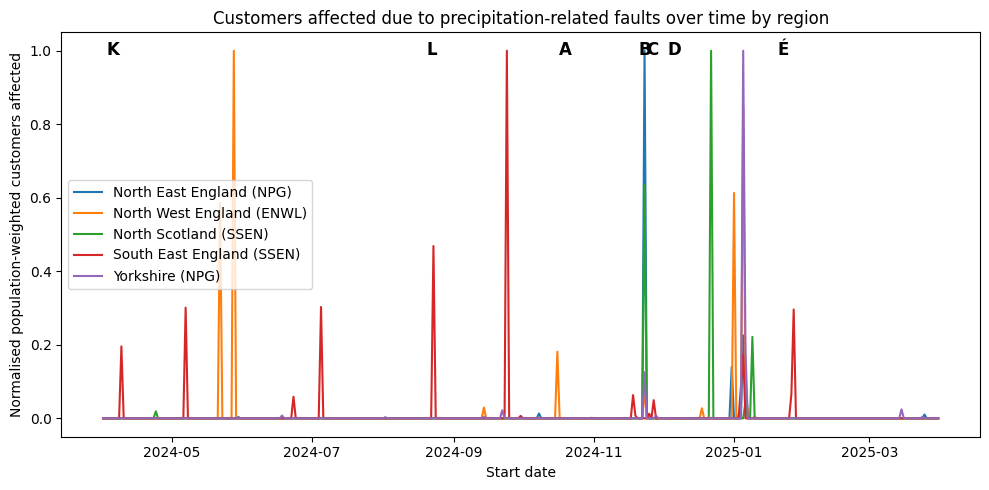

In [97]:
#Plot precip fault number of customers affected

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    subset = precip_faults[precip_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Population-weight customers affected'],
        label=region_name
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted customers affected')
plt.title('Customers affected due to precipitation-related faults over time by region')
plt.legend()
plt.tight_layout()
plt.show()

In [101]:
#Break down by rain vs. flooding codes
precip_faults_by_code = all_fault_data[all_fault_data['Category'] == 'Precipitation'].drop(['Cause', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Normalised population-weighted CML', 'Customers affected', 'Normalised population-weighted customers affected', 'Voltage', 'Location', 'Latitude', 'Longitude'], axis=1)
precip_faults_by_code['Population-weight CML'] = precip_faults_by_code['Population-weight CML'].astype(str).str.replace(',', '').astype(float)
precip_faults_by_code['Population-weight customers affected'] = precip_faults_by_code['Population-weight customers affected'].astype(float)
precip_faults_by_code = precip_faults_by_code.groupby(['Region', 'Start date', 'DNO', 'Code'], as_index=False).sum()

In [107]:
precip_faults_by_code.groupby('Region')

In [111]:
precip_faults_by_code['Population-weight CML'] = precip_faults_by_code.groupby('Region')['Population-weight CML'].transform(lambda x: x / x.max())
precip_faults_by_code['Population-weight customers affected'] = precip_faults_by_code.groupby('Region')['Population-weight customers affected'].transform(lambda x: x / x.max())
precip_faults_by_code.groupby('Region').max()

,Start date,DNO,Code,Population-weight CML,Population-weight customers affected
Region,,,,,
15.0,2025-03-25,NPG,18.0,1.0,1.0
16.0,2025-01-10,ENWL,18.0,1.0,1.0
17.0,2025-01-09,SSEN,18.0,1.0,1.0
20.0,2025-01-27,SSEN,18.0,1.0,1.0
23.0,2025-03-24,NPG,18.0,1.0,1.0


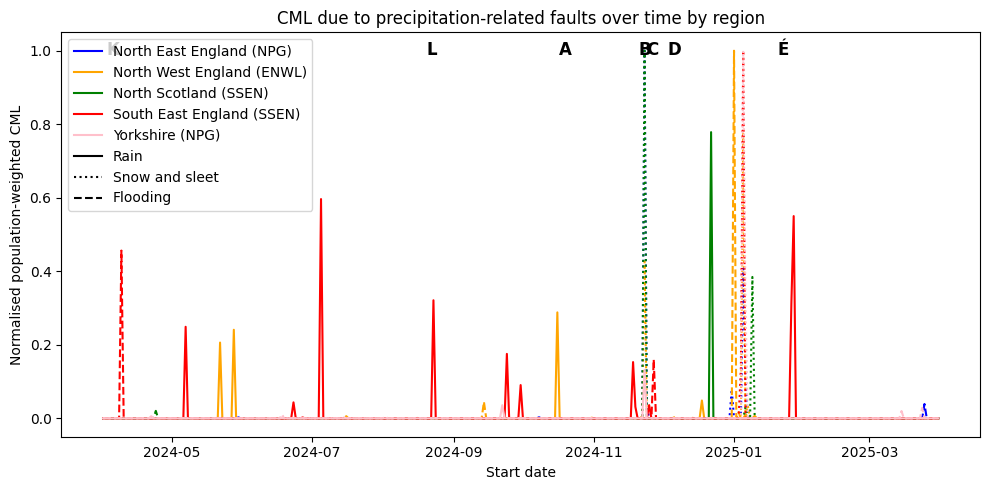

In [112]:
#Plot precip fault CML segregated by fault type

precip_codes = {
    2: 'Rain',
    3: 'Snow and sleet',
    18: 'Flooding',
}

precip_ls = {
    2: '-',
    3: ':',
    18: '--',
}

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    for code, cause in precip_codes.items():
        subset = precip_faults_by_code[(precip_faults_by_code['Region'] == region_number) & (precip_faults_by_code['Code'] == code)]
        subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
        if code == 2: #Lazy way of only adding colour labels once
            lab = region_name
        else:
            lab = None
        plt.plot(
            subset.index,
            subset['Population-weight CML'],
            label=lab,
            color=region_colors[region_number],
            ls=precip_ls[code]
        )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted CML')
plt.title('CML due to precipitation-related faults over time by region')

# Create custom legend handles
legend_lines = [
    Line2D([0], [0], color='black', linestyle=precip_ls[code], label=precip_codes[code])
    for code in precip_codes
]
all_handles = plt.gca().get_legend_handles_labels()[0] + legend_lines

plt.legend(handles=all_handles)
plt.tight_layout()
plt.show()

In [26]:
code_colors = {
    2: 'red',
    3: 'blue',
    18: 'green'
}

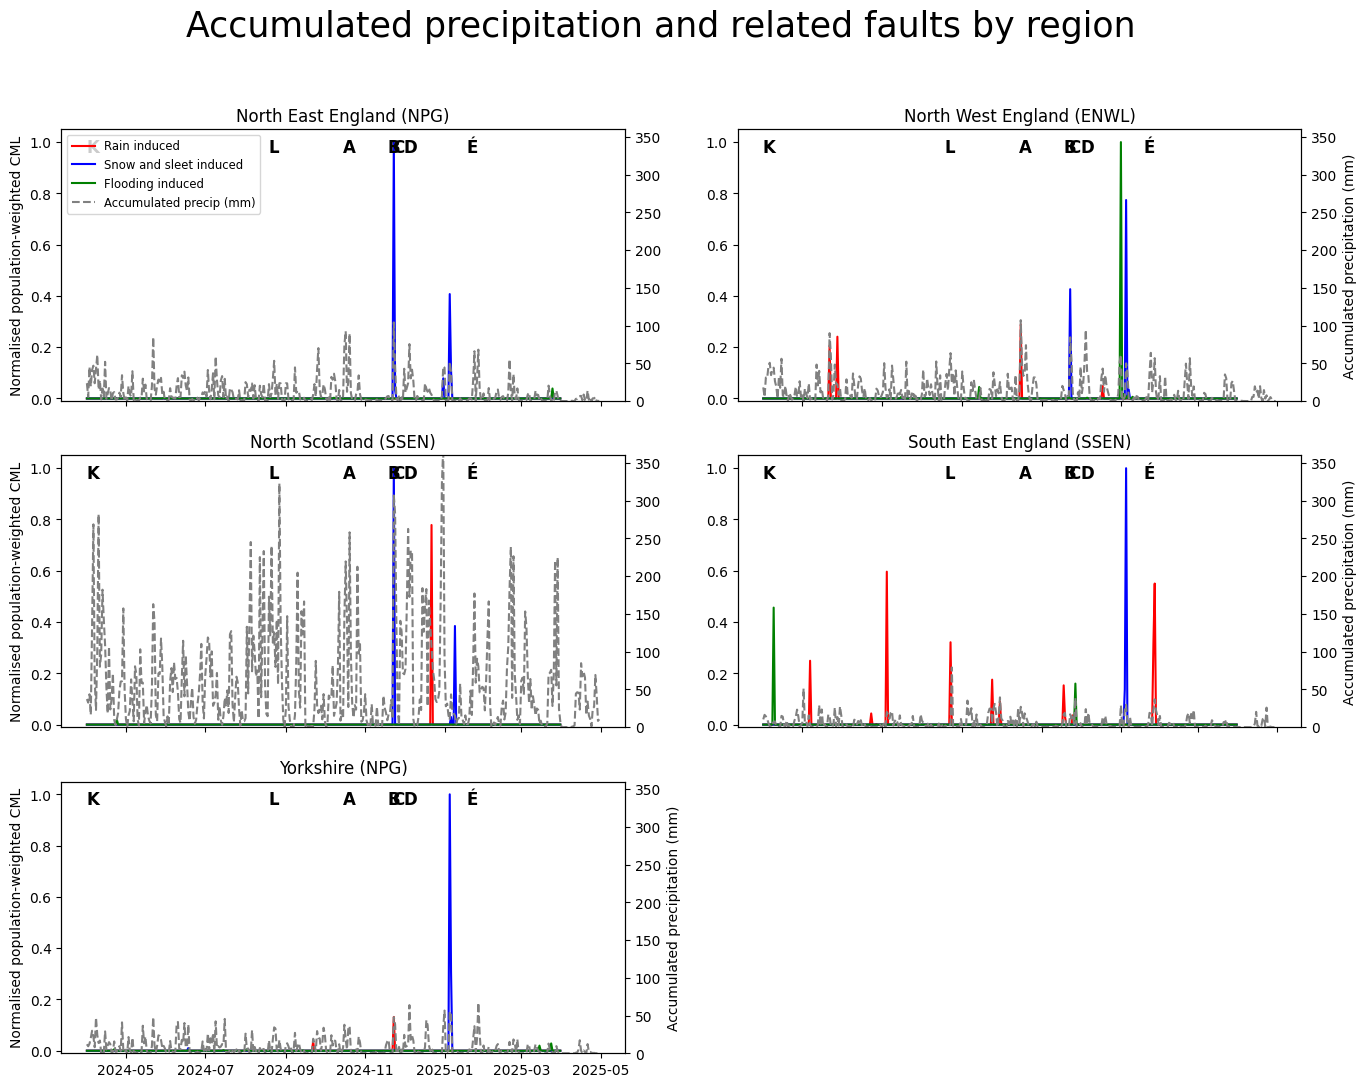

In [116]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 12), sharex=True)
axs = axs.flatten()

for i, (region_number, region_name) in enumerate(region_dict.items()):
    for code, cause in precip_codes.items():
        subset = precip_faults_by_code[(precip_faults_by_code['Region'] == region_number) & (precip_faults_by_code['Code'] == code)]
        subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
        axs[i].plot(
            subset.index,
            subset['Population-weight CML'],
            color=code_colors[code],
            label=f'{cause} induced'
        )
    axs[i].set_title(region_name)
    axs[i].set_ylim(-0.01,1.05)

    # Loop through the storms and plot the time periods
    for storm, dates in storms.items():
        start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
        end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
        # Midpoint of the storm period
        midpoint = start_date + (end_date - start_date) / 2
        # First letter of the storm name (skip "Storm " prefix)
        first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
        # Place the letter just at the top of the plot
        axs[i].text(midpoint, axs[i].set_ylim()[1]*0.9, first_letter, color='k',
                fontsize=12, fontweight='bold', ha='center', va='bottom')
        
    ax2_this = axs[i].twinx()

    ax2_this.plot(
        full_accum_precip_data_daily.index,
        full_accum_precip_data_daily[region_name.split(' (')[0]],
        color="grey",
        linestyle="--",
        label="Accumulated precip (mm)",
    )
    ax2_this.set_ylim(0,360)

    if i in [0, 2, 4]:
        axs[i].set_ylabel("Normalised population-weighted CML")
    else:
        axs[i].set_xlabel("")

    if i in [1, 3, 4]:
        ax2_this.set_ylabel("Accumulated precipitation (mm)")
    else:
        ax2_this.set_ylabel("")

    # aggregate the legends together
    handles, labels = axs[i].get_legend_handles_labels()
    handles2, labels2 = ax2_this.get_legend_handles_labels()
    # Combine the handles and labels
    combined_handles = handles + handles2
    combined_labels = labels + labels2
    # if i is 0 include the legend in the top left
    if i == 0:
        axs[i].legend(combined_handles, combined_labels, loc="upper left", fontsize="small")

axs[5].axis('off')
plt.suptitle('Accumulated precipitation and related faults by region', fontsize=25)
plt.show()


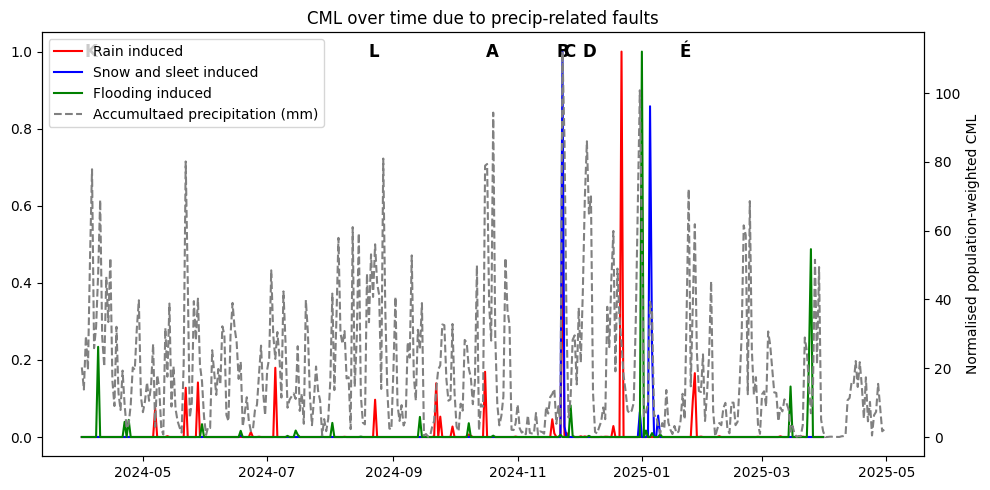

In [121]:
#Plot precip fault CML

plt.figure(figsize=(10,5))

for code, cause in precip_codes.items():
    subset = all_fault_data[all_fault_data['Category'] == 'Precipitation'].drop(['Cause', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Normalised population-weighted CML', 'Customers affected', 'Normalised population-weighted customers affected', 'Voltage', 'Location', 'Latitude', 'Longitude'], axis=1)
    subset['Population-weight CML'] = subset['Population-weight CML'].astype(str).str.replace(',', '').astype(float)
    subset['Population-weight customers affected'] = subset['Population-weight customers affected'].astype(float)
    subset = subset[(subset['Code'] == code)].groupby(['Start date'], as_index=False).sum()
    subset['Population-weight CML'] = subset["Population-weight CML"].transform(lambda x: x / x.max())
    subset['Population-weight customers affected'] = subset["Population-weight customers affected"].transform(lambda x: x / x.max())
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Population-weight CML'],
        color=code_colors[code],
        label=f'{cause} induced'
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

handles1, labels1 = plt.gca().get_legend_handles_labels()

ax2 = plt.gca().twinx()
precip_region_list = [region_name.split(' (')[0] for region_name in list(region_dict.values())]
accum_precip_subset = full_accum_precip_data_daily[precip_region_list].mean(axis=1)

ax2.plot(
    accum_precip_subset.index,
    accum_precip_subset,
    color="grey",
    linestyle="--",
    label="Accumultaed precipitation (mm)",
    )

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted CML')
plt.title('CML over time due to precip-related faults')

# aggregate the legends together

handles2, labels2 = ax2.get_legend_handles_labels()
# Combine the handles and labels
combined_handles = handles1 + handles2
combined_labels = labels1 + labels2
plt.legend(combined_handles, combined_labels, loc='upper left')
plt.tight_layout()
plt.show()

### Lightning faults

In [29]:
#lightning faults
lightning_faults = all_fault_data[all_fault_data['Category'] == 'Lightning'].drop(['Cause', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Population-weight CML', 'Customers affected', 'Population-weight customers affected', 'Voltage', 'Location', 'Latitude', 'Longitude'], axis=1)
lightning_faults = lightning_faults.groupby(['Region', 'Start date', 'DNO'], as_index=False).sum()

In [30]:
lightning_faults.head()

,Region,Start date,DNO,Code,Normalised population-weighted CML,Normalised population-weighted customers affected
0,15.0,2024-05-04,NPG,1.0,0.000032,0.000069
1,15.0,2024-05-12,NPG,2.0,0.000453,0.008580
2,15.0,2024-05-13,NPG,1.0,0.000021,0.000034
3,15.0,2024-05-26,NPG,8.0,0.027838,0.067746
4,15.0,2024-06-14,NPG,1.0,0.001821,0.004342


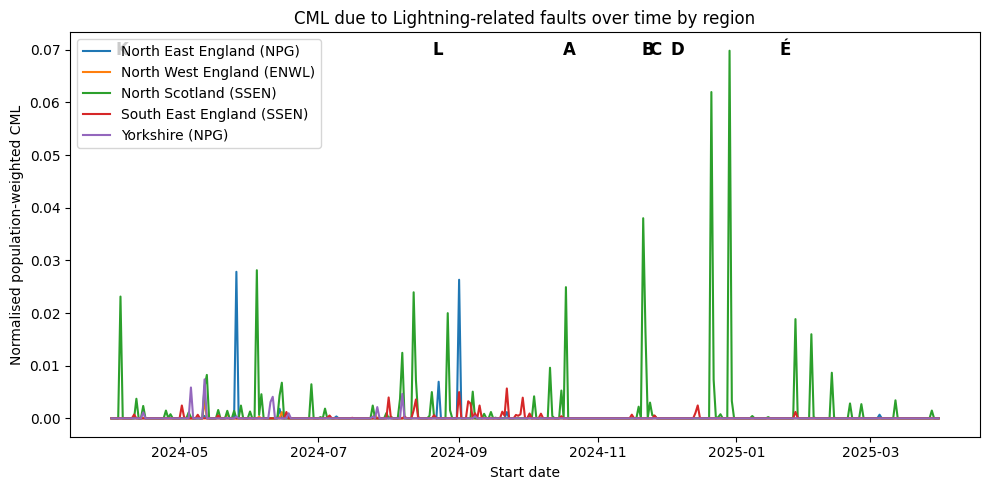

In [31]:
#Plot lightning fault CML

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    subset = lightning_faults[lightning_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Normalised population-weighted CML'],
        label=region_name
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted CML')
plt.title('CML due to Lightning-related faults over time by region')
plt.legend()
plt.tight_layout()
plt.show()

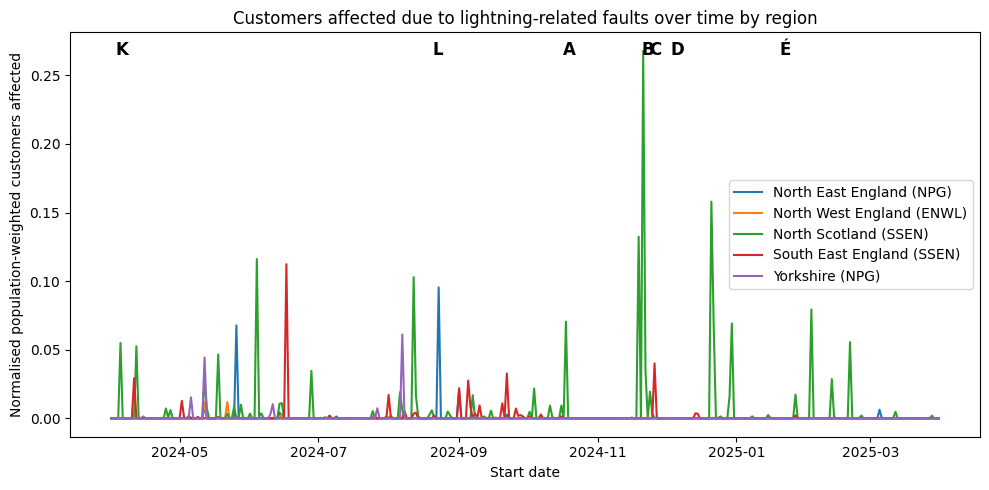

In [32]:
#Plot lightning fault number of customers affected

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    subset = lightning_faults[lightning_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Normalised population-weighted customers affected'],
        label=region_name
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted customers affected')
plt.title('Customers affected due to lightning-related faults over time by region')
plt.legend()
plt.tight_layout()
plt.show()

### Heat faults

In [33]:
#heat faults
heat_faults = all_fault_data[all_fault_data['Category'] == 'Extreme heat'].drop(['Cause', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Population-weight CML', 'Customers affected', 'Population-weight customers affected', 'Voltage', 'Location', 'Latitude', 'Longitude'], axis=1)
heat_faults = heat_faults.groupby(['Region', 'Start date', 'DNO'], as_index=False).sum()

In [34]:
heat_faults.head()

,Region,Start date,DNO,Code,Normalised population-weighted CML,Normalised population-weighted customers affected
0,20.0,2024-05-11,SSEN,7.0,0.000000,0.000000
1,20.0,2024-05-17,SSEN,7.0,0.000000,0.000000
2,20.0,2024-06-25,SSEN,35.0,0.003866,0.016328
3,20.0,2024-06-26,SSEN,14.0,0.002289,0.004207
4,20.0,2024-07-29,SSEN,7.0,0.000308,0.000979


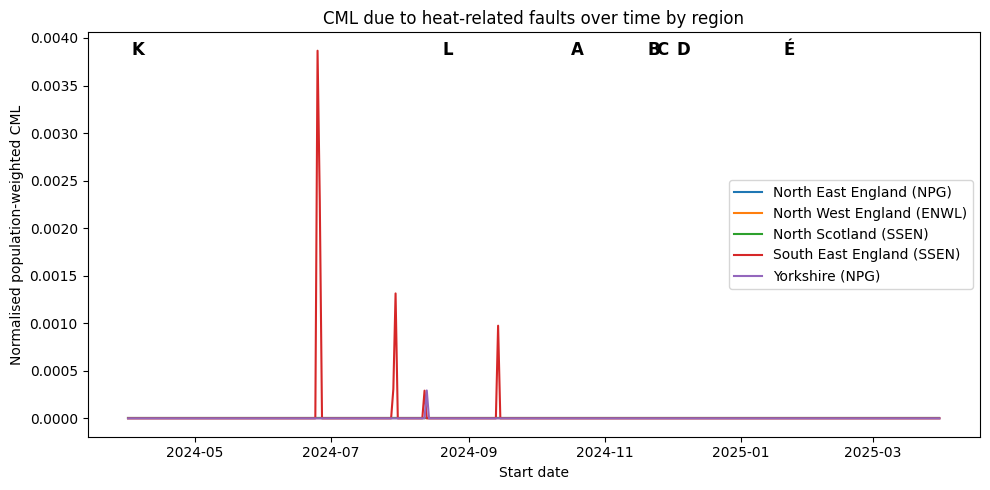

In [35]:
#Plot heat fault CML

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    subset = heat_faults[heat_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Normalised population-weighted CML'],
        label=region_name
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted CML')
plt.title('CML due to heat-related faults over time by region')
plt.legend()
plt.tight_layout()
plt.show()

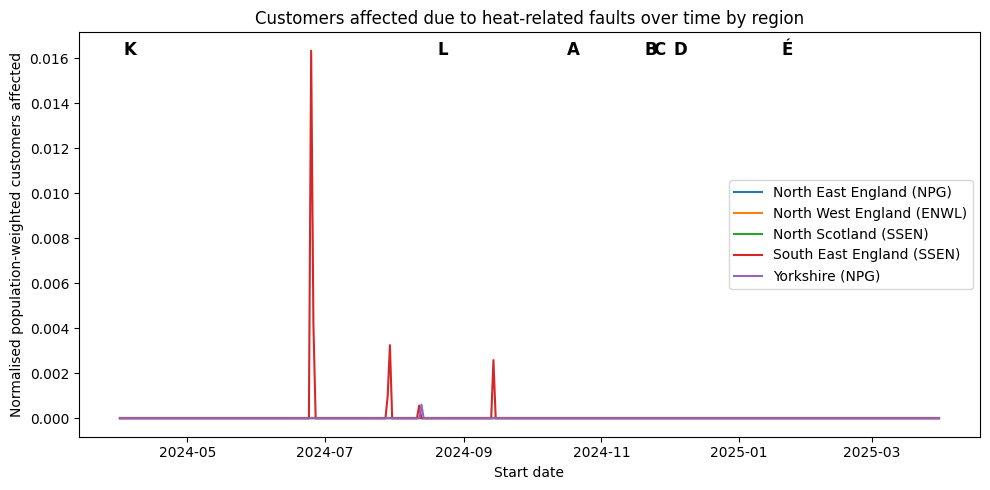

In [36]:
#Plot heat fault number of customers affected

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    subset = heat_faults[heat_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Normalised population-weighted customers affected'],
        label=region_name
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted customers affected')
plt.title('Customers affected due to heat-related faults over time by region')
plt.legend()
plt.tight_layout()
plt.show()

### Ice/frost faults

In [37]:
#ice faults
ice_faults = all_fault_data[all_fault_data['Category'] == 'Extreme cold and ice'].drop(['Cause', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Population-weight CML', 'Customers affected', 'Population-weight customers affected', 'Voltage', 'Location', 'Latitude', 'Longitude'], axis=1)
ice_faults = ice_faults.groupby(['Region', 'Start date', 'DNO'], as_index=False).sum()

In [38]:
ice_faults.head()

,Region,Start date,DNO,Code,Normalised population-weighted CML,Normalised population-weighted customers affected
0,15.0,2024-05-13,NPG,5.0,0.008188,0.040179
1,15.0,2024-10-06,NPG,5.0,0.004807,0.017677
2,15.0,2025-01-06,NPG,4.0,0.000047,0.000069
3,16.0,2024-11-22,ENWL,4.0,0.000004,0.000019
4,17.0,2024-11-20,SSEN,4.0,0.007032,0.008043


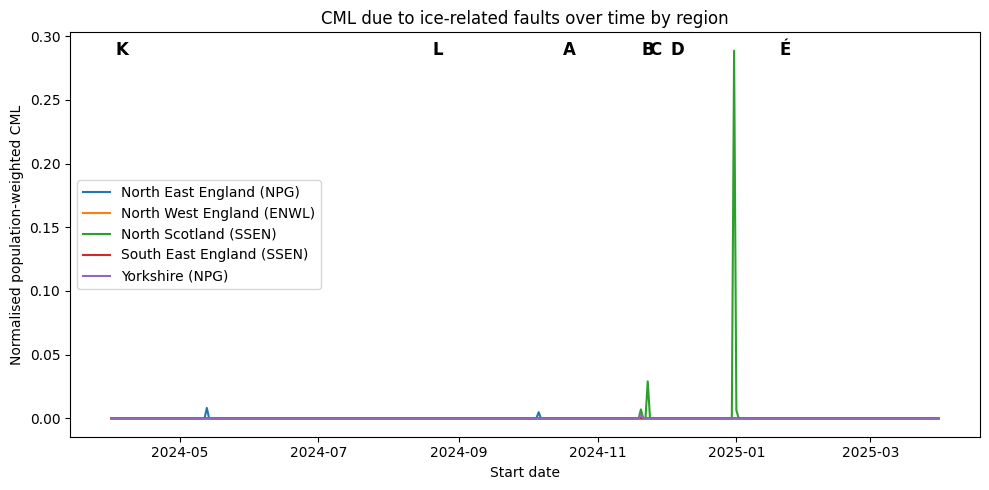

In [39]:
#Plot ice fault CML

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    subset = ice_faults[ice_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Normalised population-weighted CML'],
        label=region_name
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted CML')
plt.title('CML due to ice-related faults over time by region')
plt.legend()
plt.tight_layout()
plt.show()

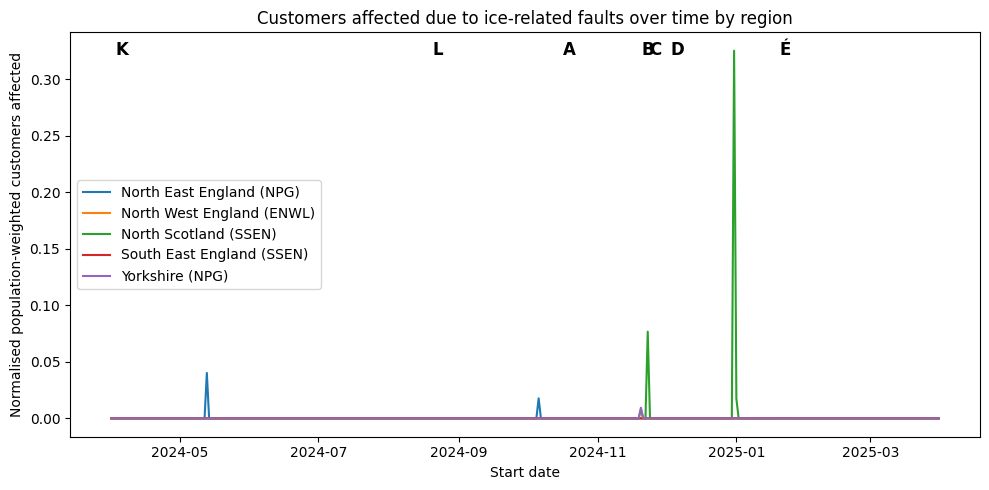

In [40]:
#Plot ice fault number of customers affected

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    subset = ice_faults[ice_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Normalised population-weighted customers affected'],
        label=region_name
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted customers affected')
plt.title('Customers affected due to ice-related faults over time by region')
plt.legend()
plt.tight_layout()
plt.show()

### Fallen tree faults

In [41]:
#tree faults
tree_faults = all_fault_data[all_fault_data['Category'] == 'Trees'].drop(['Cause', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Population-weight CML', 'Customers affected', 'Population-weight customers affected', 'Voltage', 'Location', 'Latitude', 'Longitude'], axis=1)
tree_faults = tree_faults.groupby(['Region', 'Start date', 'DNO'], as_index=False).sum()

In [42]:
tree_faults.head()

,Region,Start date,DNO,Code,Normalised population-weighted CML,Normalised population-weighted customers affected
0,15.0,2024-04-03,NPG,23.0,0.000046,0.000034
1,15.0,2024-04-06,NPG,69.0,0.010711,0.027429
2,15.0,2024-04-07,NPG,23.0,0.002328,0.004790
3,15.0,2024-04-10,NPG,23.0,0.000014,0.000172
4,15.0,2024-04-19,NPG,47.0,0.014755,0.027739


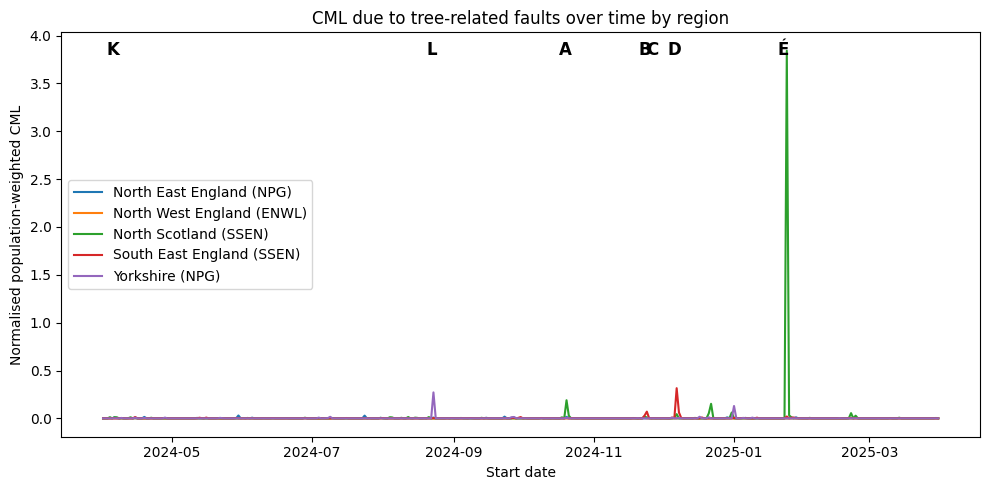

In [43]:
#Plot tree fault CML

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    subset = tree_faults[tree_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Normalised population-weighted CML'],
        label=region_name
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted CML')
plt.title('CML due to tree-related faults over time by region')
plt.legend()
plt.tight_layout()
plt.show()

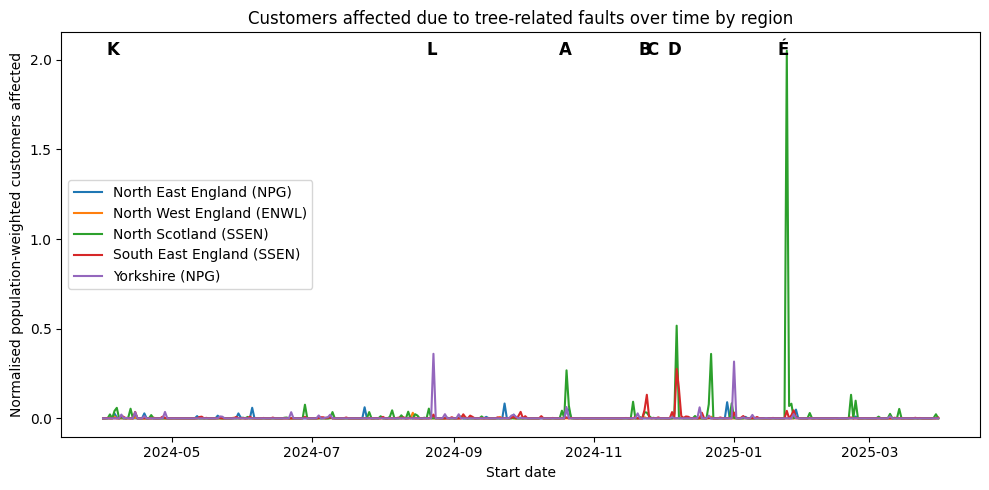

In [44]:
#Plot tree fault number of customers affected

plt.figure(figsize=(10,5))

for region_number, region_name in region_dict.items():
    subset = tree_faults[tree_faults['Region'] == region_number]
    subset = subset.set_index('Start date').reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
    plt.plot(
        subset.index,
        subset['Normalised population-weighted customers affected'],
        label=region_name
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip "Storm " prefix)
    first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
    # Place the letter just at the top of the plot
    plt.text(midpoint, plt.ylim()[1]*0.93, first_letter, color='k',
             fontsize=12, fontweight='bold', ha='center', va='bottom')

plt.xlabel('Start date')
plt.ylabel('Normalised population-weighted customers affected')
plt.title('Customers affected due to tree-related faults over time by region')
plt.legend()
plt.tight_layout()
plt.show()